In [1]:
from copy import deepcopy
from subpred.util import load_df
import obonet
import networkx as nx

In [2]:
def get_protein_dataset(
    datasets_folder_path: str,
    organism_ids: set = set(),
    evidence_at_protein_level=True,
    reviewed: bool = True,
):
    df_uniprot = load_df("uniprot", datasets_folder_path)
    if organism_ids:
        df_uniprot = df_uniprot[df_uniprot.organism_id.isin(organism_ids)]
    if evidence_at_protein_level:
        df_uniprot = df_uniprot[df_uniprot.protein_existence == 1]
    if reviewed:
        df_uniprot = df_uniprot[df_uniprot.reviewed]
    return df_uniprot

In [3]:
def get_go_annotations(
    datasets_folder_path: str, proteins: set, include_iea: bool = True
):
    df_goa_uniprot = load_df("go", datasets_folder_path)
    df_goa_uniprot = df_goa_uniprot[df_goa_uniprot.Uniprot.isin(proteins)]
    if not include_iea:
        df_goa_uniprot = df_goa_uniprot[df_goa_uniprot.evidence_code != "IEA"]
    df_goa_uniprot = df_goa_uniprot.reset_index(drop=True)
    return df_goa_uniprot

In [4]:
def add_ancestors(df_uniprot_goa, graph_go):
    df_uniprot_goa = df_uniprot_goa.assign(
        ancestors=[
            nx.descendants(graph_go, go_id) | {go_id} for go_id in df_uniprot_goa.go_id
        ]
    )

    df_uniprot_goa = (
        df_uniprot_goa.explode("ancestors")
        .drop("go_id", axis=1)
        .rename(columns={"ancestors": "go_id"})
        .drop_duplicates()
        .reset_index(drop=True)
    )

    return df_uniprot_goa

In [5]:
def get_id_update_dict(graph, field="alt_id"):
    dict_update_id = dict()
    for node, alt_ids in graph.nodes(data=field):
        if not alt_ids:
            continue
        for alt_id in alt_ids:
            dict_update_id[alt_id] = node

    return dict_update_id

In [ ]:
def get_filtered_go_graph(
    graph_go: nx.MultiDiGraph,
    root_node: str,
    protein_subset: set,
    inter_go_relations: set = {"is_a"},
    aspects: set = {"molecular_function"},
):
    ## Filter graph by protein dataset
    graph_go = graph_go.subgraph(nodes=protein_subset)
    print(len(graph_go.nodes()))
    ## Filter graph by aspect/namespace
    graph_go = graph_go.subgraph(
        nodes=[
            node
            for node, data in graph_go.nodes(data=True)
            if data["namespace"] in aspects
        ]
    )
    print(len(graph_go.nodes()))

    ## Filter graph by relations
    graph_go = graph_go.edge_subgraph(
        edges={
            edge for edge in graph_go.edges(keys=True) if edge[2] in inter_go_relations
        }
    )
    print(len(graph_go.nodes()))

    ## Filter graph by function
    go_name_to_id = {data["name"]: id for id, data in graph_go.nodes(data=True)}
    tmtp_ancestors = nx.ancestors(graph_go, go_name_to_id[root_node])
    graph_go = graph_go.subgraph(tmtp_ancestors | {go_name_to_id[root_node]})
    print(len(graph_go.nodes()))
    return graph_go.copy()

## Main function

In [6]:
# Funtion parameters TODO create function
organism_ids = {83333}
datasets_folder_path = "data/datasets"
go_obo_path = "data/raw/ontologies/go.obo"
chebi_obo_path = "data/raw/ontologies/chebi.obo"


In [7]:
## Get protein dataset for organism
df_uniprot = get_protein_dataset(
    datasets_folder_path=datasets_folder_path,
    organism_ids=organism_ids,
    evidence_at_protein_level=True,
    reviewed=True,
)

In [8]:
graph_go = obonet.read_obo(go_obo_path, ignore_obsolete=True)

In [9]:
df_uniprot_goa = get_go_annotations(
    datasets_folder_path=datasets_folder_path,
    proteins=set(df_uniprot.index.tolist()),
    include_iea=True,
)

In [10]:
# update go ids
dict_update_go_id = get_id_update_dict(graph_go)
df_uniprot_goa.go_id = df_uniprot_goa.go_id.apply(
    lambda go_id: dict_update_go_id[go_id]
    if go_id in dict_update_go_id.keys()
    else go_id
)


In [11]:
## Add ancestors to goa, i.e. more abstract terms
df_uniprot_goa = add_ancestors(df_uniprot_goa=df_uniprot_goa, graph_go=graph_go)
print(len(graph_go.nodes()))


43248


In [ ]:
# Filtering GO graph
graph_go = get_filtered_go_graph(
    graph_go=graph_go,
    root_node="transmembrane transporter activity",
    protein_subset=set(df_uniprot_goa.go_id.unique()),
    inter_go_relations={"is_a"},
    aspects={"molecular_function"},
)


## Filtering Chebi data

In [14]:
# Read chebi ontology
graph_chebi = obonet.read_obo(chebi_obo_path, ignore_obsolete=True)
chebi_id_to_name = {id: data["name"] for id, data in graph_chebi.nodes(data=True)}
chebi_name_to_id = {y: x for x, y in chebi_id_to_name.items()}
## Filter by manually annotated entries
print(len(graph_chebi.nodes()))
graph_chebi = graph_chebi.subgraph(
    [x for x, data in graph_chebi.nodes(data=True) if "3_STAR" in data["subset"]]
)
print(len(graph_chebi.nodes()))

## Filter by substrates

## Add ancestors to get full graph


164519
60547


## GO-Chebi mapping

In [15]:
# Annotate with chebi primary input substrates
## Read go-chebi mapping
df_go_to_chebi = load_df("go_chebi", datasets_folder_path)

# update chebi ids
dict_update_chebi_id = get_id_update_dict(graph_chebi)
df_go_to_chebi.chebi_id = df_go_to_chebi.chebi_id.apply(
    lambda chebi_id: dict_update_chebi_id[chebi_id]
    if chebi_id in dict_update_chebi_id.keys()
    else chebi_id
)
# update go ids
df_go_to_chebi.go_id = df_go_to_chebi.go_id.apply(
    lambda go_id: dict_update_go_id[go_id]
    if go_id in dict_update_go_id.keys()
    else go_id
)


## Filter for primary input substrates:
df_go_to_chebi = (
    df_go_to_chebi[df_go_to_chebi.relation == "has_primary_input"]
    .reset_index(drop=True)
    .drop("relation", axis=1)
)
## Filter by graphs:
print(df_go_to_chebi.shape[0])
df_go_to_chebi = df_go_to_chebi[
    df_go_to_chebi.go_id.isin(graph_go.nodes())
].reset_index(drop=True)
print(df_go_to_chebi.shape[0])
df_go_to_chebi = df_go_to_chebi[
    df_go_to_chebi.chebi_id.isin(graph_chebi.nodes())
].reset_index(drop=True)
print(df_go_to_chebi.shape[0])

## Add ancestors
INCLUDE_ANCESTOR_CHEBI_IDS = False
# TODO filter for original chebi terms again?

if INCLUDE_ANCESTOR_CHEBI_IDS:
    df_go_to_chebi = df_go_to_chebi.drop("chebi_term", axis=1)
    df_go_to_chebi.chebi_id = [
        nx.ancestors(graph_chebi, chebi_id) | {chebi_id}
        for chebi_id in df_go_to_chebi.chebi_id
    ]
    df_go_to_chebi = df_go_to_chebi.explode("chebi_id").reset_index(drop=True)
    df_go_to_chebi = df_go_to_chebi.assign(
        chebi_term=df_go_to_chebi.chebi_id.map(chebi_id_to_name)
    )

df_go_to_chebi = df_go_to_chebi.drop_duplicates().reset_index(drop=True)

df_go_to_chebi

1996
335
331


,go_id,chebi_id,chebi_term
0,GO:0015625,CHEBI:28163,iron(III) hydroxamate
1,GO:0042900,CHEBI:22599,arabinose
2,GO:0042907,CHEBI:15318,xanthine
3,GO:0015578,CHEBI:37684,mannose
4,GO:0015153,CHEBI:26546,rhamnose
...,...,...,...
326,GO:0015415,CHEBI:35780,phosphate ion
327,GO:0005351,CHEBI:24636,proton
328,GO:0005351,CHEBI:16646,carbohydrate
329,GO:0005363,CHEBI:17306,maltose


## Mapping Uniprot to GO to Chebi

In [16]:
df_uniprot_go_chebi = df_uniprot_goa[["Uniprot", "go_id"]].merge(
    df_go_to_chebi, how="inner", on="go_id"
)

df_uniprot_go_chebi = df_uniprot_go_chebi.drop_duplicates().reset_index(drop=True)
df_uniprot_go_chebi

,Uniprot,go_id,chebi_id,chebi_term
0,A5A627,GO:0005216,CHEBI:24867,monoatomic ion
1,P02930,GO:0005216,CHEBI:24867,monoatomic ion
2,P02931,GO:0005216,CHEBI:24867,monoatomic ion
3,P09348,GO:0005216,CHEBI:24867,monoatomic ion
4,P0A6E6,GO:0005216,CHEBI:24867,monoatomic ion
...,...,...,...,...
2280,P76352,GO:0015230,CHEBI:24040,flavin adenine dinucleotide
2281,P76352,GO:0044610,CHEBI:58210,FMN(3-)
2282,Q59385,GO:0043682,CHEBI:29036,copper(2+)
2283,Q59385,GO:0140581,CHEBI:49552,copper(1+)


In [17]:
protein_count = df_uniprot_go_chebi.Uniprot.unique().shape[0]
protein_count

331

## Calculating pairwise overlaps for substrates with more then n substrates

In [18]:
import pandas as pd

dict_chebi_to_uniprot = (
    df_uniprot_go_chebi[["chebi_id", "Uniprot"]]
    .groupby("chebi_id")
    .apply(lambda x: set(x.Uniprot))
    .to_dict()
)
dict_chebi_to_uniprot_filtered = {
    x: y
    for x, y in dict_chebi_to_uniprot.items()
    if (len(y) > 19) and (len(y) < protein_count // 2)
}

## Calculate protein annotation overlaps for go and chebi, create plot
sorted_chebi_order = [
    tup[0]
    for tup in sorted(
        [
            (chebi_id, len(proteins))
            for chebi_id, proteins in dict_chebi_to_uniprot_filtered.items()
        ],
        key=lambda x: x[1],
        reverse=True,
    )
]


In [19]:
substrates = sorted_chebi_order
df_substrate_overlaps = pd.DataFrame(0, columns=substrates, index=substrates)

for chebi_id1 in substrates:
    for chebi_id2 in substrates:
        intersection = (
            dict_chebi_to_uniprot_filtered[chebi_id1]
            & dict_chebi_to_uniprot_filtered[chebi_id2]
        )
        overlap = len(intersection)
        df_substrate_overlaps.at[chebi_id1, chebi_id2] = overlap

df_substrate_overlaps.columns = df_substrate_overlaps.columns.map(chebi_id_to_name)
df_substrate_overlaps.index = df_substrate_overlaps.index.map(chebi_id_to_name)

df_substrate_overlaps

,monoatomic ion,monoatomic cation,inorganic cation,organic anion,organic acid,carboxylic acid anion,carbohydrate,proton,chemical entity,amino acid,metal cation,amide,peptide,L-alpha-amino acid zwitterion,carbohydrate derivative,monosaccharide,monocarboxylic acid,inorganic anion
monoatomic ion,121,102,94,21,21,21,19,62,56,10,43,10,8,4,5,7,7,7
monoatomic cation,102,102,94,19,19,19,17,62,56,9,43,9,7,3,5,7,6,5
inorganic cation,94,94,95,18,18,18,16,62,50,9,43,9,7,3,5,7,6,5
organic anion,21,19,18,90,82,80,7,14,17,46,6,6,4,29,6,2,22,3
organic acid,21,19,18,82,82,80,7,14,17,46,6,4,2,29,1,2,22,2
carboxylic acid anion,21,19,18,80,80,80,7,14,17,46,6,4,2,29,1,2,22,2
carbohydrate,19,17,16,7,7,7,69,14,17,0,2,0,0,0,6,25,4,0
proton,62,62,62,14,14,14,14,62,41,6,11,5,5,2,3,6,6,3
chemical entity,56,56,50,17,17,17,17,41,56,8,16,5,4,3,5,7,6,4
amino acid,10,9,9,46,46,46,0,6,8,46,4,2,1,29,0,0,1,1


## Plots

<AxesSubplot:title={'center':'Substrate molecular species overlaps in E. coli for substrates with 20 or more transport proteins'}>

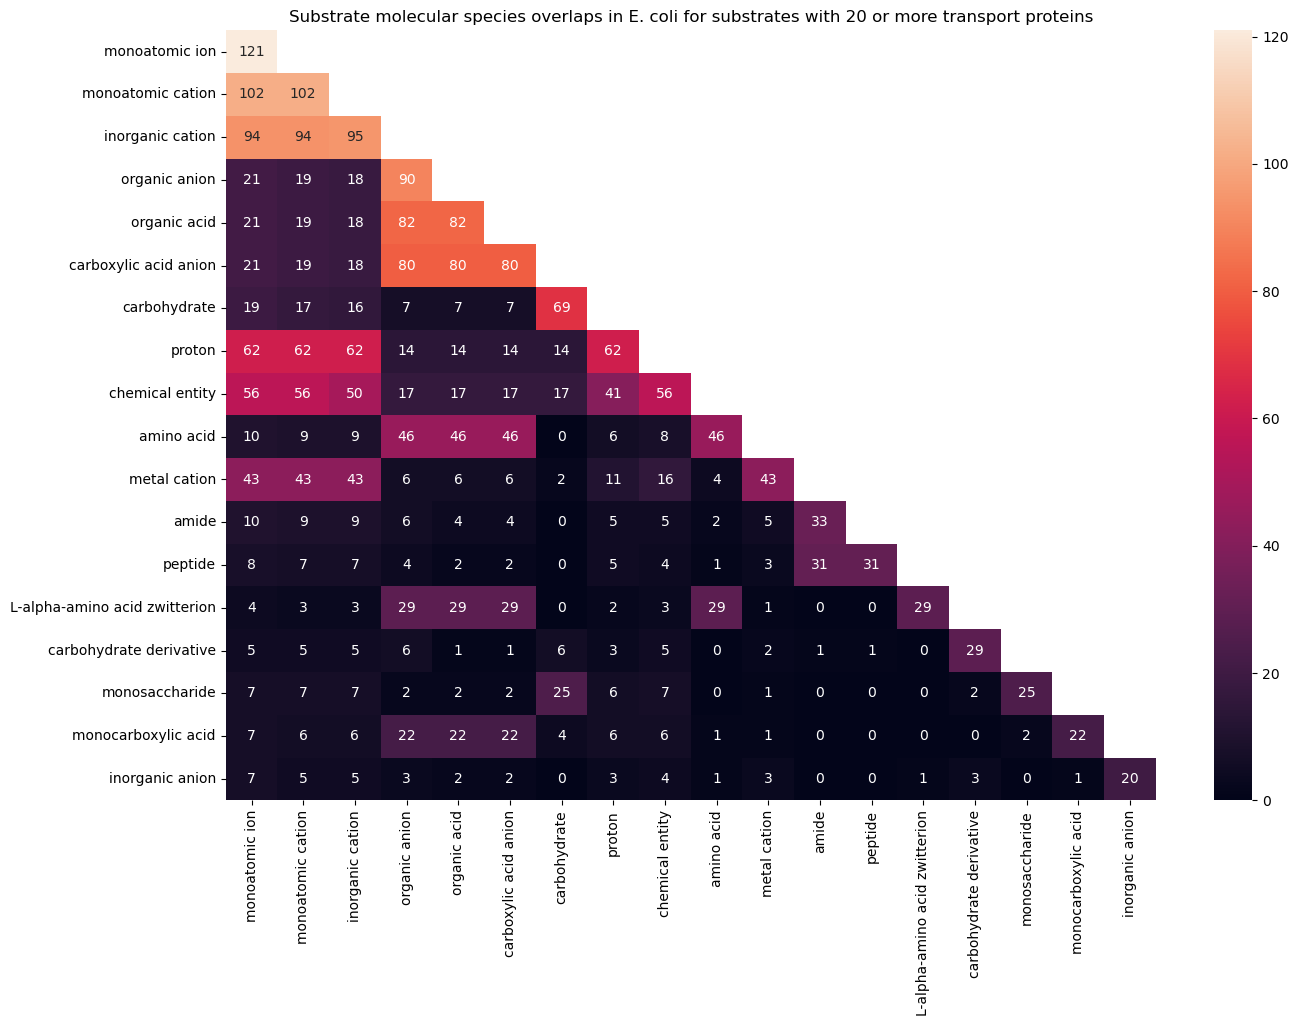

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))
plt.title(
    "Substrate molecular species overlaps in E. coli for substrates with 20 or more transport proteins"
)

triangle = True
mask = None
if triangle:
    mask = np.triu(np.ones_like(df_substrate_overlaps), k=1)
sns.heatmap(df_substrate_overlaps, annot=True, fmt=".0f", mask=mask)


In [21]:
# filter graph
graph_chebi_filtered = graph_chebi.subgraph(dict_chebi_to_uniprot_filtered.keys())
# add edges to show relations. edge if there is a path
graph_chebi_filtered = graph_chebi_filtered.copy()

In [22]:
{e[2] for e in graph_chebi.edges(keys=True)}

{'has_functional_parent',
 'has_parent_hydride',
 'has_part',
 'has_role',
 'is_a',
 'is_conjugate_acid_of',
 'is_conjugate_base_of',
 'is_enantiomer_of',
 'is_substituent_group_from',
 'is_tautomer_of'}

In [23]:
graph_chebi_is_a = graph_chebi.edge_subgraph(
    [e for e in graph_chebi.edges(keys=True) if e[2] == "is_a"]
).copy()
# TODO only filtering for is_a does not account for tautomers, enantiomers.


In [24]:
nodes = list(graph_chebi_filtered.nodes())
chebi_id_to_uniprot_count = {
    chebi_id: len(uniprot) for chebi_id, uniprot in dict_chebi_to_uniprot.items()
}
nodes_to_count = {node: chebi_id_to_uniprot_count[node] for node in nodes}
nodes = [y[0] for y in sorted(nodes_to_count.items(), key=lambda x: x[1], reverse=True)]


In [25]:
for node1 in nodes:
    for node2 in nodes:
        if node1 == node2:
            continue
        if nx.has_path(graph_chebi_is_a, node1, node2) and not nx.has_path(
            graph_chebi_filtered, node1, node2
        ):
            graph_chebi_filtered.add_edge(node1, node2)


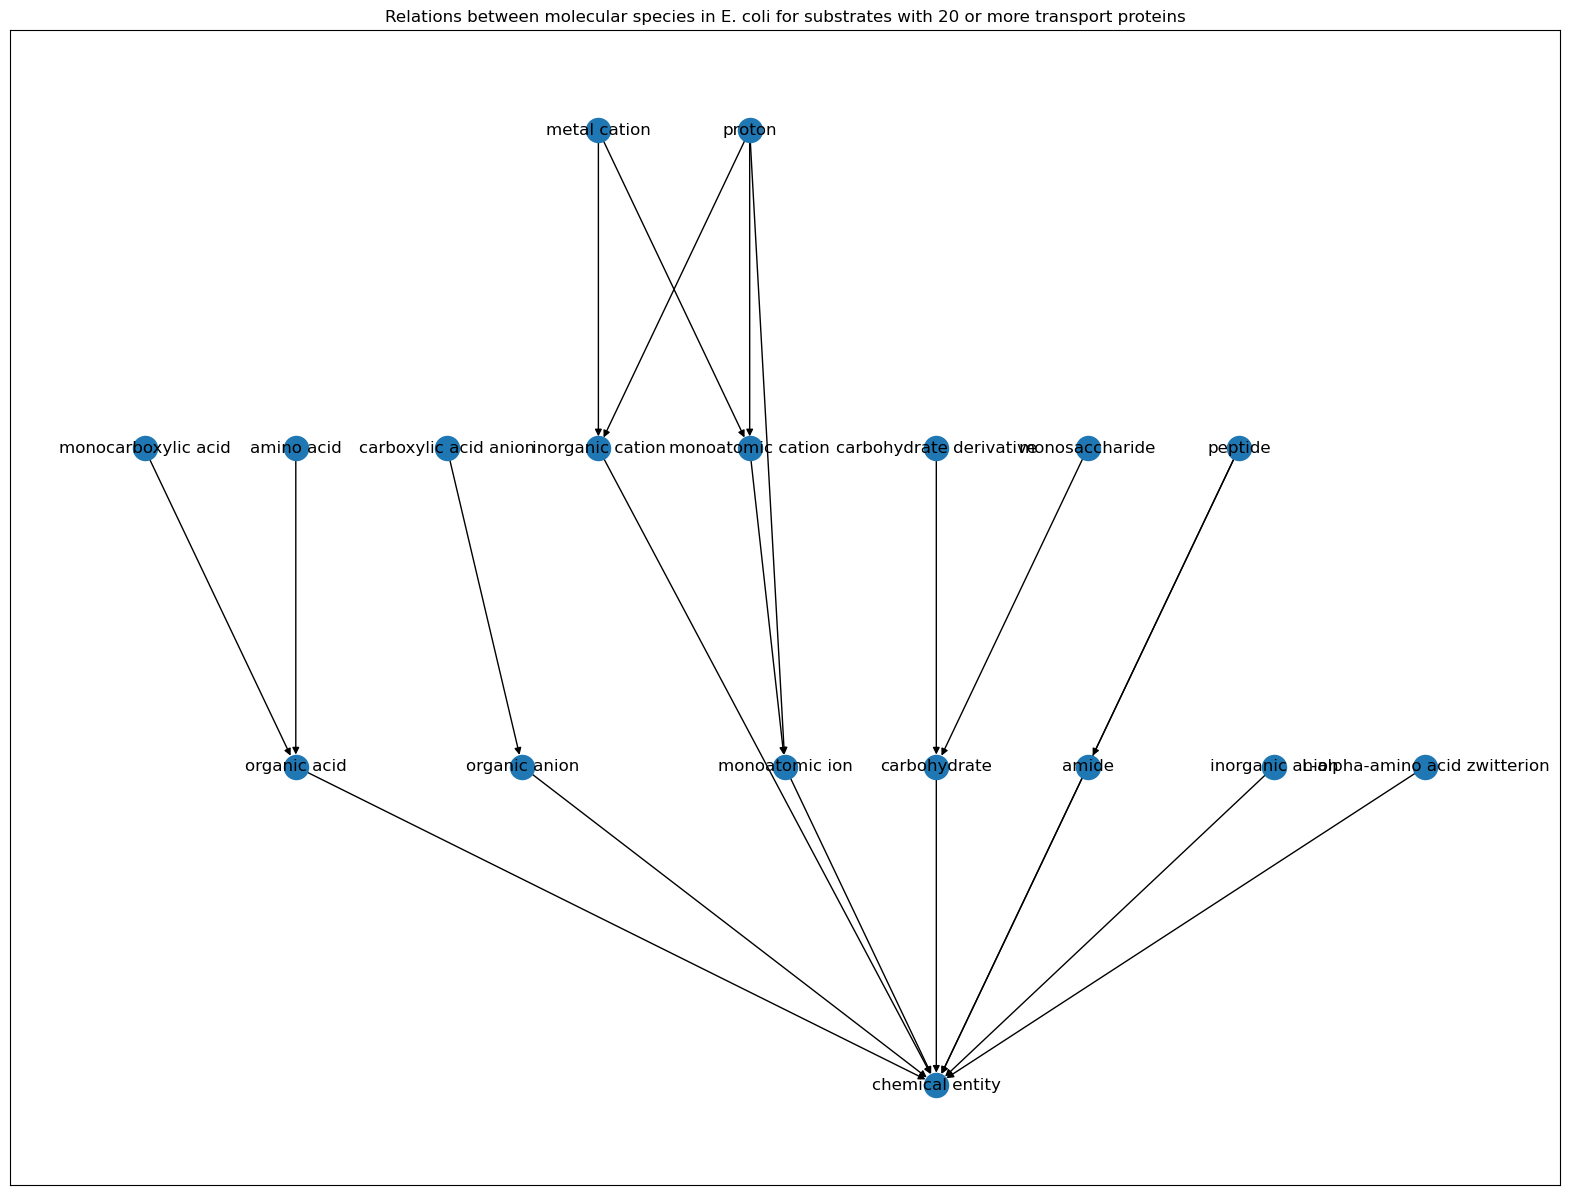

In [26]:
import networkx as nx


plt.figure(figsize=(20, 15))
plt.title(
    "Relations between molecular species in E. coli for substrates with 20 or more transport proteins"
)

layout = nx.nx_agraph.graphviz_layout(
    graph_chebi_filtered,
    prog="dot",
    root=chebi_name_to_id["chemical entity"],
)

nx.draw_networkx(
    graph_chebi_filtered,
    pos=layout,
    labels={node: name for node, name in graph_chebi_filtered.nodes(data="name")},
)
# nx.draw_networkx_labels(graph_chebi_filtered)

In [27]:
# Stats and Plots, options for filtering

## create overlap heatmap between substrates

### merge uniprot to go with go to chebi
